In [1]:
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
sys.path.append('..')
import lib

In [2]:
n_qubits = 4
dim = 2 ** n_qubits
rho = lib.randomPureState(dim)


projectors_cnt = 10
measurements_cnt = 100

train_size = projectors_cnt * measurements_cnt
train_X, train_y = lib.generate_dataset(rho, projectors_cnt, measurements_cnt)
train_y = train_y.astype('float64')

In [3]:
x_ph = tf.placeholder(dtype=tf.complex64, shape=[None, dim, dim])
y_ph = tf.placeholder(dtype=tf.float32, shape=[None])

model = lib.BaselineModel(x_ph, y_ph)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [4]:
def adaptive_proj(sigma):
    val, vec = np.linalg.eig(sigma)
    idx = np.random.choice(range(len(val)), p=val.real)
    eigvec = vec[:, idx]
    proj = lib.projectorOnto(eigvec)
    proj /= np.trace(proj)
    return proj

In [5]:
epoches = 50_000
batch_size = 5
loss_history = []
metrics_history = []
fidelity_history = []

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

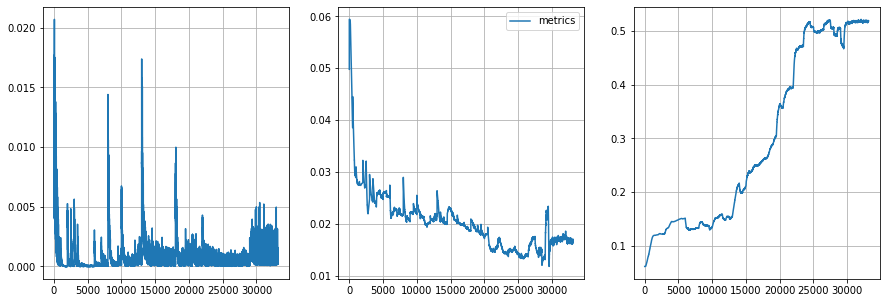

Epoch: 33150, Loss: 0.00020027055870741606, Metrics: 0.016906024967990017


KeyboardInterrupt: 

In [6]:
for t in range(epoches):
    batch_idx = np.random.randint(0, len(train_X), size=batch_size)
    batch_idx = np.hstack((batch_idx, -1))
    loss_t, _ = sess.run([model.loss, model.optimize], {x_ph: train_X[batch_idx], y_ph: train_y[batch_idx]})
    loss_history.append(loss_t)
    
    sigma = sess.run(model.sigma)
    measurements_rho = np.array([lib.simulator.bornRule(x, rho) for x in train_X])
    measurements_sigma = np.array([lib.simulator.bornRule(x, sigma) for x in train_X])
    
    diff = abs(measurements_sigma - measurements_rho)
    metrics_history.append(diff.mean())
    fidelity_history.append(lib.fidelity(rho, sigma))
    
    if t % 500 == 0 and t < 30_000:
        new_proj = adaptive_proj(sigma)
        train_X = np.vstack((train_X, np.expand_dims(new_proj, 0) ))
        ones, zeroes = lib.measure(measurements_cnt, rho, new_proj)
        train_y = np.hstack((train_y, ones / measurements_cnt))
    
    if t % 50 == 0:
        clear_output(True)
        plt.figure(figsize=[15, 5])
        plt.subplot(1, 3, 1)
        plt.plot(loss_history)
        plt.grid()
        plt.subplot(1, 3, 2)
        plt.plot(metrics_history, label='metrics')
        plt.legend()
        plt.grid()
        plt.subplot(1, 3, 3)
        plt.plot(fidelity_history)
        plt.grid()
        plt.show()
        print(f'Epoch: {t}, Loss: {loss_t}, Metrics: {diff.mean()}')

In [7]:
train_X.shape

(70, 16, 16)

In [8]:
sigma = sess.run(model.sigma)
lib.fidelity(rho, sigma)

0.5198615415783353

In [9]:
projectors_cnt = 70
measurements_cnt = 100

train_size = projectors_cnt * measurements_cnt
train_X, train_y = lib.generate_dataset(rho, projectors_cnt, measurements_cnt)
train_y = train_y.astype('float64')

In [10]:
epoches = 30_000
loss_history = []
metrics_history = []
fidelity_history = []

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

/home/popov/anaconda3/envs/dl/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


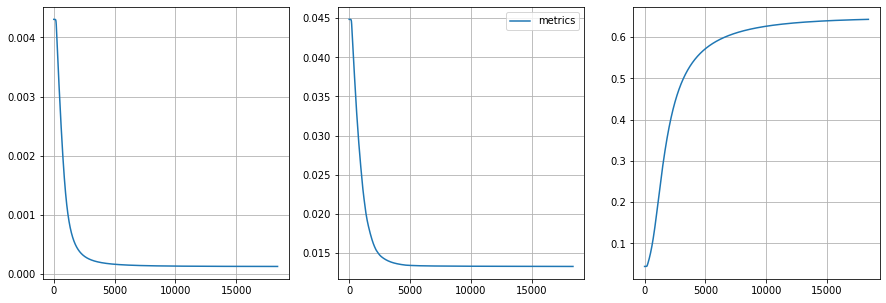

Epoch: 18400, Loss: 0.00012789855827577412, Metrics: 0.013258529031628299


KeyboardInterrupt: 

In [11]:
for t in range(epoches):
    loss_t, _ = sess.run([model.loss, model.optimize], {x_ph: train_X, y_ph: train_y})
    loss_history.append(loss_t)
    
    sigma = sess.run(model.sigma)
    measurements_rho = np.array([lib.simulator.bornRule(x, rho) for x in train_X])
    measurements_sigma = np.array([lib.simulator.bornRule(x, sigma) for x in train_X])
    
    diff = abs(measurements_sigma - measurements_rho)
    metrics_history.append(diff.mean())
    fidelity_history.append(lib.fidelity(rho, sigma))
    
    if t % 50 == 0:
        clear_output(True)
        plt.figure(figsize=[15, 5])
        plt.subplot(1, 3, 1)
        plt.plot(loss_history)
        plt.grid()
        plt.subplot(1, 3, 2)
        plt.plot(metrics_history, label='metrics')
        plt.legend()
        plt.grid()
        plt.subplot(1, 3, 3)
        plt.plot(fidelity_history)
        plt.grid()
        plt.show()
        print(f'Epoch: {t}, Loss: {loss_t}, Metrics: {diff.mean()}')

In [12]:
sigma = sess.run(model.sigma)
lib.fidelity(rho, sigma)

0.643429619577293